# Multi-layer Perceptron Classifier

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [75]:
clean_train = "clean_train.csv"
clean_val = "clean_val.csv"
clean_test = "clean_test.csv"
train_subsam = "train_subsam.csv"
train_smote = "train_smote.csv"
dnn_model = "mlp_model.joblib"

rand_mlp = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train, num_classes=2)

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Feature Scaling

In [6]:
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

df_under[num_cols] = scaler.fit_transform(df_under[num_cols])
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
217427,4,5,0,8,41,9,0.124780,0.0005,0,1,1,0,0,0,0.069566,0.146043,0.109568,0.742268
10168,4,5,0,20,31,5,0.527241,0.0008,1,0,0,0,0,0,0.032423,0.068360,0.051311,0.742268
614308,38,41,0,4,36,3,0.115993,0.0002,0,1,1,0,0,0,0.004020,0.008956,0.007219,0.793814


## Model Training

### Model Tuning

In [27]:
def create_model():
    model = keras.Sequential()

    model.add(layers.Dense(64, input_shape=[len(X_train.keys())], activation="relu"))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    custom_optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss="binary_crossentropy",
                  optimizer=custom_optimizer,
                  metrics=["accuracy"])
    return model

In [48]:
mlp_model = create_model()

mlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1216      
                                                                 
 dense_13 (Dense)            (None, 512)               33280     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 35009 (136.75 KB)
Trainable params: 35009 (136.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",     # metrica a monitorear (puedes ser tambien "val_accuracy")
    factor=0.5,             # factor por el cual reducir el learning rate
    patience=10,            # numero de epocas sin mejora antes de reducir el learning rate
    min_lr=1e-5             # limite inferior para el learning rate
)

In [21]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",         # metrica a monitorear (puedes ser tambien "val_loss")
    patience=10,                    # numero de epocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True       # restaurar los pesos del modelo al mejor punto de validación
)

In [29]:
history = mlp_model.fit(X_train,
                        y_train,
                        epochs=100,
                        batch_size=1000,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        # callbacks=[reduce_learning_rate, early_stopping]
)

Epoch 1/100
627/627 [==============================] - 5s 7ms/step - loss: 0.4408 - accuracy: 0.8183 - val_loss: 0.3849 - val_accuracy: 0.8359
Epoch 2/100
627/627 [==============================] - 4s 7ms/step - loss: 0.3709 - accuracy: 0.8393 - val_loss: 0.3470 - val_accuracy: 0.8628
Epoch 3/100
627/627 [==============================] - 4s 7ms/step - loss: 0.3399 - accuracy: 0.8587 - val_loss: 0.3260 - val_accuracy: 0.8634
Epoch 4/100
627/627 [==============================] - 4s 7ms/step - loss: 0.3227 - accuracy: 0.8693 - val_loss: 0.3187 - val_accuracy: 0.8667
Epoch 5/100
627/627 [==============================] - 4s 7ms/step - loss: 0.3156 - accuracy: 0.8730 - val_loss: 0.3384 - val_accuracy: 0.8585
Epoch 6/100
627/627 [==============================] - 4s 6ms/step - loss: 0.3103 - accuracy: 0.8753 - val_loss: 0.3026 - val_accuracy: 0.8778
Epoch 7/100
627/627 [==============================] - 4s 7ms/step - loss: 0.3059 - accuracy: 0.8776 - val_loss: 0.2995 - val_accuracy: 0.8791

In [30]:
results = mlp_model.evaluate(X_test, y_test, verbose=1)

print("Accuracy:", round(results[1], 4))

4204/4204 [==============================] - 6s 1ms/step - loss: 0.3383 - accuracy: 0.8889
Accuracy: 0.8889


In [31]:
df_hist = pd.DataFrame(history.history)
df_hist["epoch"] = history.epoch

df_hist.iloc[[0,1,-2,-1]]

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.440751,0.818313,0.384865,0.835885,0
1,0.370901,0.839343,0.347038,0.862834,1
98,0.225951,0.913403,0.248084,0.908288,98
99,0.225672,0.913377,0.259194,0.904476,99


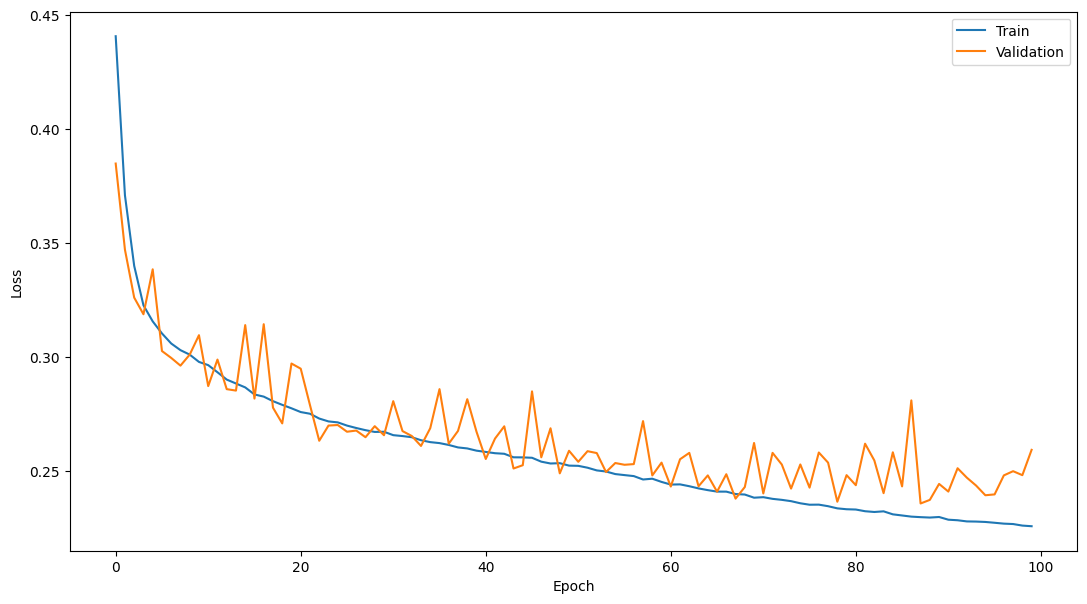

In [32]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df_hist["epoch"], df_hist["loss"], label="Train")
plt.plot(df_hist["epoch"], df_hist["val_loss"], label = "Validation")
plt.legend()
plt.show()

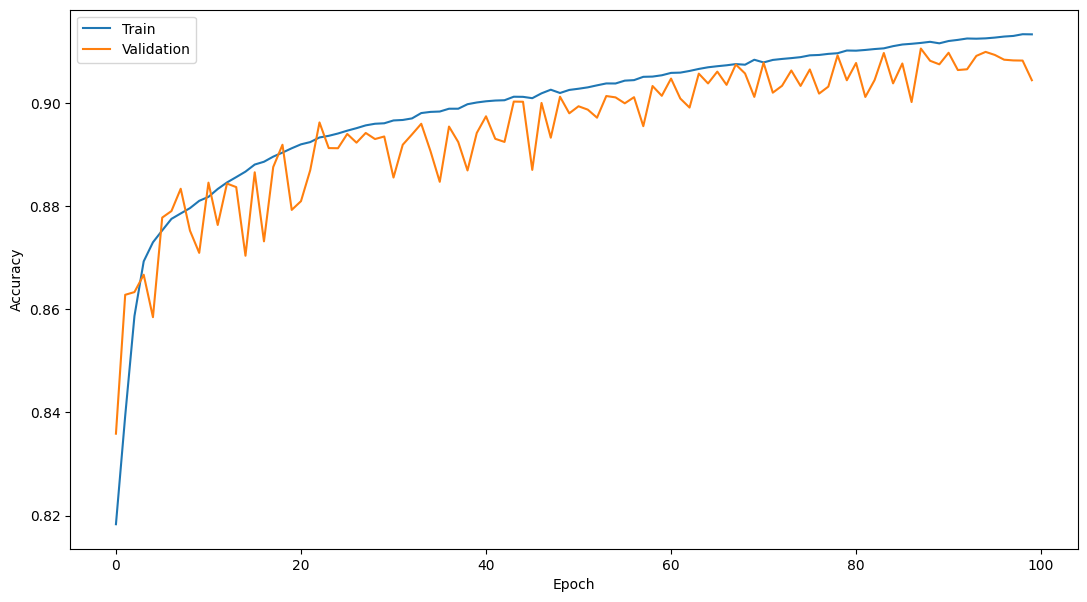

In [33]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(df_hist["epoch"], df_hist["accuracy"], label="Train")
plt.plot(df_hist["epoch"], df_hist["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

### Balanced Datasets

In [34]:
mlp_sam = create_model()

**Subsample Dataset**

In [35]:
his_sam = mlp_sam.fit(X_under,
                      y_under,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val))

Epoch 1/100
220/220 [==============================] - 3s 9ms/step - loss: 1389.2849 - accuracy: 0.5376 - val_loss: 3.0560 - val_accuracy: 0.1814
Epoch 2/100
220/220 [==============================] - 2s 7ms/step - loss: 5.6680 - accuracy: 0.5517 - val_loss: 3.2835 - val_accuracy: 0.1797
Epoch 3/100
220/220 [==============================] - 2s 7ms/step - loss: 2.1438 - accuracy: 0.5831 - val_loss: 3.2358 - val_accuracy: 0.1789
Epoch 4/100
220/220 [==============================] - 2s 8ms/step - loss: 1.4898 - accuracy: 0.5965 - val_loss: 3.2633 - val_accuracy: 0.1788
Epoch 5/100
220/220 [==============================] - 2s 7ms/step - loss: 1.2237 - accuracy: 0.5964 - val_loss: 3.2513 - val_accuracy: 0.1787
Epoch 6/100
220/220 [==============================] - 2s 8ms/step - loss: 1.2361 - accuracy: 0.5940 - val_loss: 3.1667 - val_accuracy: 0.1787
Epoch 7/100
220/220 [==============================] - 2s 8ms/step - loss: 0.7961 - accuracy: 0.5951 - val_loss: 3.1966 - val_accuracy: 0.1

In [36]:
res_sam = mlp_sam.evaluate(X_test, y_test, verbose=1)

print("Accuracy SubSampling:", round(res_sam[1], 4))

4204/4204 [==============================] - 6s 1ms/step - loss: 2.6372 - accuracy: 0.1775
Accuracy SubSampling: 0.1775


**SMOTE Dataset**

In [37]:
his_sam = mlp_sam.fit(X_smote,
                      y_smote,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val))

Epoch 1/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.8743 - accuracy: 0.4997 - val_loss: 2.2858 - val_accuracy: 0.1772
Epoch 2/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.7396 - accuracy: 0.4998 - val_loss: 2.2002 - val_accuracy: 0.1771
Epoch 3/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.7070 - accuracy: 0.4996 - val_loss: 1.9464 - val_accuracy: 0.1772
Epoch 4/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 1.9533 - val_accuracy: 0.1772
Epoch 5/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 1.9546 - val_accuracy: 0.1772
Epoch 6/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 1.9501 - val_accuracy: 0.1772
Epoch 7/100
1034/1034 [==============================] - 7s 7ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 1.9449 - val_ac

In [38]:
res_sam = mlp_sam.evaluate(X_test, y_test, verbose=1)

print("Accuracy SMOTE:", round(res_sam[1], 4))

4204/4204 [==============================] - 6s 1ms/step - loss: 1.9537 - accuracy: 0.1776
Accuracy SMOTE: 0.1776


## Model Evaluation

### Classification Report

In [40]:
y_pred = mlp_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

4204/4204 [==============================] - 5s 1ms/step


In [41]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8889
Precisión:    0.8841
Sensibilidad: 0.7106
F1-score:     0.7585


In [42]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8899    0.9870    0.9360    110629
           1     0.8782    0.4342    0.5811     23869

    accuracy                         0.8889    134498
   macro avg     0.8841    0.7106    0.7585    134498
weighted avg     0.8878    0.8889    0.8730    134498



### Confusion Matrix

In [43]:
cm_mlp = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_mlp)

[[0.81184107 0.01069161]
 [0.10040298 0.07706434]]


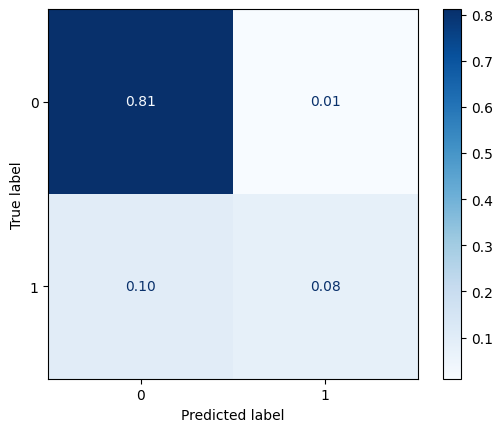

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp.plot(cmap="Blues", values_format=".2f")

### ROC Curve & AUC

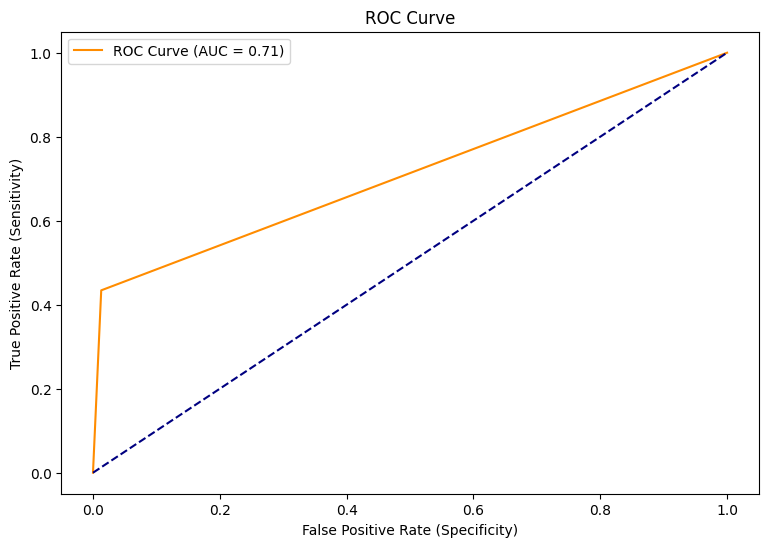

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [69]:
class MLP_Model(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlp_model = keras.Sequential()

        self.mlp_model.add(layers.Dense(64, input_shape=[18], activation="relu"))
        self.mlp_model.add(layers.Dense(512, activation="relu"))
        self.mlp_model.add(layers.Dropout(0.3))
        self.mlp_model.add(layers.Dense(1, activation="sigmoid"))

        custom_optimizer = keras.optimizers.Adam(learning_rate=0.001)

        self.mlp_model.compile(loss="binary_crossentropy",
                               optimizer=custom_optimizer,
                               metrics=["accuracy"])

        self.reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-5)

        self.early_stopping = keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=10,
            restore_best_weights=True)

    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                          train_size=0.75,
                                                          random_state=rand_mlp)

        self.mlp_model.fit(X_train,
                           y_train,
                           epochs=100,
                           batch_size=1000,
                           verbose=1,
                           validation_data=(X_val, y_val),
                           callbacks=[reduce_learning_rate, early_stopping]
                           )
        return self

    def predict(self, X, y=None):
        y_mlp = self.mlp_model.predict(X)
        y_pred = (y_mlp > 0.5).astype(int)

        return y_pred

In [70]:
mlp_pipeline = Pipeline([("mlp_model", MLP_Model())])

### Test the Pipeline

**Internal Partition**

In [ ]:
mlp_pipeline.fit(X_train, y_train)

y_pred = mlp_pipeline.predict(X_val)

In [72]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.8925
Precisión:    0.8492
Sensibilidad: 0.7512
F1-score:     0.7869


**External Partition**

In [73]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

In [ ]:
mlp_pipeline.fit(X_train_val, y_train_val)

y_pred = mlp_pipeline.predict(X_test)

In [76]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8885
Precisión:    0.8601
Sensibilidad: 0.7254
F1-score:     0.7680


**The Best Model**

In [ ]:
mlp_pipeline.fit(X_train, y_train)

y_pred = mlp_pipeline.predict(X_val)

In [81]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9042
Precisión:    0.8717
Sensibilidad: 0.7766
F1-score:     0.8126


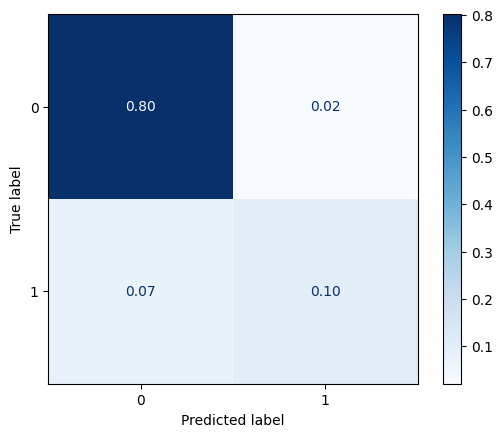

In [84]:
cm_mlp = confusion_matrix(y_val, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp.plot(cmap="Blues", values_format=".2f")

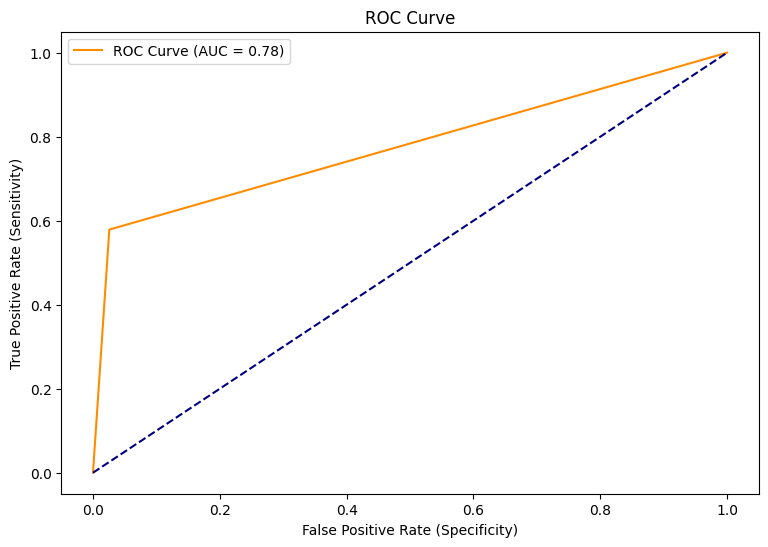

In [85]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [ ]:
# try:
#     joblib.dump(mlp_pipeline, dnn_model)

#     meta_model = joblib.load(dnn_model)
#     print(f"Multi-layer Perceptron loaded...")

# except Exception as err:
#     print("Error:", str(err))

In [108]:
y_pred = mlp_pipeline.predict(X_test)
y_pred = y_pred.flatten().tolist()

df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

4204/4204 [==============================] - 5s 1ms/step


In [109]:
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
132942,21,38,1,16,25,2,0.027149,0.003200,0,0,0,0,0,0,0.027109,0.079816,0.075453,0.845361,0,0
41014,17,20,0,7,47,3,0.027149,0.000900,0,0,1,0,1,0,0.017825,0.039808,0.022114,0.484536,0,0
21867,3,30,1,17,43,2,0.104072,0.000500,0,1,1,0,0,0,0.001910,0.004801,0.002667,0.484536,1,1
132312,5,5,1,20,29,7,0.617647,0.004500,1,0,0,0,0,0,0.126955,0.279856,0.241027,0.773196,0,0
115264,14,38,1,20,29,11,0.020362,0.010701,0,0,0,0,0,0,0.006821,0.015603,0.014813,0.845361,0,0
36966,17,20,0,16,30,11,0.135747,0.000700,0,0,0,0,0,1,0.001910,0.004801,0.004889,0.896907,0,0
41025,41,45,0,20,34,2,0.325792,0.000300,0,0,0,0,0,0,0.019189,0.042809,0.035726,0.742268,0,0
125131,4,17,1,17,44,1,0.190045,0.000200,0,0,1,0,1,0,0.002862,0.004001,0.002222,0.484536,0,0
8769,3,45,1,4,41,9,0.063348,0.000100,0,0,1,0,1,0,0.005325,0.004801,0.002667,0.484536,1,1
24904,47,52,0,10,36,11,0.325792,0.002200,0,0,0,1,0,0,0.024100,0.053611,0.043463,0.721649,0,0
